# Transmitters

2 transmitters are considered:

- 2 W tail-light, lambertian pattern, 20$^\circ$ half angle. This imitates the transmitter configuration used in the following article: Béchadergue, B., Chassagne, L., & Guan, H. (2017, October). "_A visible light-based system for automotive relative positioning_". IEEE SENSORS

- real headlight pattern from Memedi, A., Tebruegge, C., Jahneke, J., & Dressler, F. (2018, December). "_Impact of vehicle type and headlight characteristics on vehicular VLC performance_". In 2018 IEEE Vehicular Networking Conference (VNC) (pp. 1-8). IEEE.

In [1]:
%matplotlib inline
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np

## tail-light, 2 W, lambertian, 20$^\circ$ half angle

In [2]:
power      = 2.0;  # [W]
half_angle = 20.0; # [deg]

angle_sweep_resolution = 0.02; # [deg]
# enlarge square array (by sqrt(2)x) so that the integrator doesn't hit bounds
angle_sweep_high       =  90*np.sqrt(2)
angle_sweep_low        = -90*np.sqrt(2)
angle_sweep_numsamples = int(((angle_sweep_high - angle_sweep_low)/angle_sweep_resolution))
angle_sweep_array_sqr  = np.linspace(angle_sweep_low, angle_sweep_high, num=angle_sweep_numsamples)

lambertian_order = np.round(-np.log(2)/np.log(np.cos(np.deg2rad(half_angle))));
pattern          = np.cos(np.deg2rad(angle_sweep_array_sqr))**lambertian_order;
pattern_indexed  = np.concatenate((np.expand_dims(angle_sweep_array_sqr, axis=0), np.expand_dims(pattern, axis=0)), axis=0)

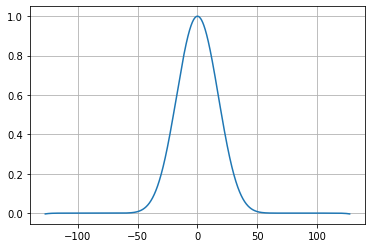

In [3]:
fig, ax = plt.subplots()
ax.plot(pattern_indexed[0,:], pattern_indexed[1,:])
ax.grid()
plt.show()

we need to compute the normalization factor for this pattern, which is the area under the angle-wise relative illumination curve shown above

the total irradiance from the TX (over the whole area it shines on), is (power x integral_of_the_relative_illum_curve / normalization_factor )

we'll compute the actual integral during the simulation trapezoidally for higher accuracy, but the angle span will always be really small anyhow 

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def radSymSrc3dIntegral( rad_pat, eps1_xy, eps2_xy, eps1_zy, eps2_zy ):
    id0_eps1_xy = find_nearest(rad_pat[0,:], eps1_xy);
    id0_eps2_xy = find_nearest(rad_pat[0,:], eps2_xy);
    id0_eps1_zy = find_nearest(rad_pat[0,:], eps1_zy);
    id0_eps2_zy = find_nearest(rad_pat[0,:], eps2_zy);

    id_zero = int(rad_pat.shape[1]/2); # works because python is 0 indexed
    
    id_list_numsamples_xy = int(abs(id0_eps2_xy-id0_eps1_xy)+1);
    id_list_numsamples_zy = int(abs(id0_eps2_zy-id0_eps1_zy)+1);
    
    id_list_fwd_xy = np.linspace(id0_eps2_xy, id0_eps1_xy, num=id_list_numsamples_xy);
    id_list_bwd_xy = np.linspace(id0_eps1_xy, id0_eps2_xy, num=id_list_numsamples_xy);
    id_list_fwd_zy = np.linspace(id0_eps2_zy, id0_eps1_zy, num=id_list_numsamples_zy);
    id_list_bwd_zy = np.linspace(id0_eps1_zy, id0_eps2_zy, num=id_list_numsamples_zy);
    
    vol_fwd = 0;
    for i in range(1, id_list_numsamples_xy): # i=2:length(id_list_fwd_xy)
        for j in range(1, id_list_numsamples_zy): # j=2:length(id_list_fwd_zy)
            radial_pos_i_xy_i_zy     = int(np.sqrt((id_list_fwd_xy[i] - id_zero)**2 + (id_list_fwd_zy[j] - id_zero)**2))
            radial_pos_im1_xy_i_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_i_xy_im1_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_im1_xy_im1_zy = radial_pos_i_xy_i_zy-2; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            avg_y_val = (rad_pat[1,radial_pos_i_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_i_xy_im1_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_im1_zy+id_zero] )/4 ;
            vol_fwd = vol_fwd + (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_im1_xy_i_zy+id_zero])* \
                (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_i_xy_im1_zy+id_zero])* \
                avg_y_val;

    vol_bwd = 0;
    for i in range(1, id_list_numsamples_xy): # i=2:length(id_list_bwd_xy)
        for j in range(1, id_list_numsamples_zy): # j=2:length(id_list_bwd_zy)
            radial_pos_i_xy_i_zy     = int(np.sqrt((id_list_bwd_xy[i] - id_zero)**2 + (id_list_bwd_zy[j] - id_zero)**2))
            radial_pos_im1_xy_i_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_i_xy_im1_zy   = radial_pos_i_xy_i_zy-1; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            radial_pos_im1_xy_im1_zy = radial_pos_i_xy_i_zy-2; # this is an approximation, while this should really go into the expression above, since that would not hit a different LUT value for very small angles, we do this
            avg_y_val = (rad_pat[1,radial_pos_i_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_i_zy+id_zero] + \
                rad_pat[1,radial_pos_i_xy_im1_zy+id_zero] + \
                rad_pat[1,radial_pos_im1_xy_im1_zy+id_zero] )/4 ;
            vol_bwd = vol_bwd + (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_im1_xy_i_zy+id_zero])* \
                (rad_pat[0,radial_pos_i_xy_i_zy+id_zero]-rad_pat[0,radial_pos_i_xy_im1_zy+id_zero])* \
                avg_y_val;

    # we compensate the above approximations by averaging forward and backward passes, 
    # based on the fact that the curve we're doing this on is very smooth.  
    vol = (vol_fwd+vol_bwd)/2;
    return vol

In [5]:
normalization_factor = radSymSrc3dIntegral( pattern_indexed, -90, 90, -90, 90);
print("normalization factor: ", normalization_factor)

normalization factor:  1769.3030716069761


In [6]:
np.savez('../tx_lambertian_20deg_2W.npz', 
         power = power,
         half_angle = half_angle,
         normalization_factor = normalization_factor)

# headlight (LbSedan1)

low beams are typically 50-55Ws, but our scenarios cover tail-lights, and we're just trying to understand how much effect real headlight patterns have compared to lambertians, so we just use a lower power setting with the same pattern. We use the same power setting as the lambertian for fair comparison

first get Agon's measurements from the veins_vlc repo

In [5]:
!wget -L https://raw.githubusercontent.com/veins/veins_vlc/35ae3f2fb8c276e1d75d8bf263fc674e6a33b21c/examples/veins-vlc/radiationPatterns.txt

--2023-07-18 17:16:50--  https://raw.githubusercontent.com/veins/veins_vlc/35ae3f2fb8c276e1d75d8bf263fc674e6a33b21c/examples/veins-vlc/radiationPatterns.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10700029 (10M) [text/plain]
Saving to: ‘radiationPatterns.txt’

radiationPatterns.t 100%[===================>]  10,20M  5,67MB/s    in 1,8s    

2023-07-18 17:16:53 (5,67 MB/s) - ‘radiationPatterns.txt’ saved [10700029/10700029]



In [6]:
power = 2.0;  # [W]

In [7]:
with open("radiationPatterns.txt","r") as f:
    radpatfile_lineslist_asString = f.readlines()
    
# make sure you submit lines with number arrays here, not the index lines
def getarray_from_radpatfile(lineslistfromradpatfile, linenum_0indexed):
    # last element is a newline, that's why the list goes up to -1
    return np.array([float(i) for i in lineslistfromradpatfile[linenum_0indexed].split(" ")[:-1]])

In [ ]:
LbSedan1_patternL_flat         = getarray_from_radpatfile(radpatfile_lineslist_asString, 7)
LbSedan1_anglesL_flat          = getarray_from_radpatfile(radpatfile_lineslist_asString, 9)

## we don't need these, we'll just simulate for 1 TX
## and our power transmission model disregards spectral diversity without loss of generality
#LbSedan1_patternR_flat         = getarray_from_radpatfile(radpatfile_lineslist_asString, 8)
#LbSedan1_anglesR_flat          = getarray_from_radpatfile(radpatfile_lineslist_asString, 10)
#LbSedan1_spectralEmission_flat = getarray_from_radpatfile(radpatfile_lineslist_asString, 11)

# this part is adapted from the veins_vlc readers for the radiation pattern file
def getpatternval(irradPhi, irradTheta, angles, flatpattern):
    indexPhi   = (np.round((irradPhi - angles[0]) / angles[2])).astype(int)
    indexTheta = (np.round((irradTheta - angles[3]) / angles[5])).astype(int)
    rowLength  = (np.round((angles[1] - angles[0] + angles[2]) / angles[2])).astype(int)
    indexFlat  = (rowLength * indexTheta) + indexPhi
    value      = flatpattern[indexFlat]
    return value

# 0: angle start, 1: angle end, 2: angle resolution for the lateral axis. 
# Same goes for 3,4,5 respectively, but for the vertical (azimuth?) axis.
irradPhiArray   = np.arange(LbSedan1_anglesL_flat[0], LbSedan1_anglesL_flat[1], LbSedan1_anglesL_flat[2])
irradThetaArray = np.arange(LbSedan1_anglesL_flat[3], LbSedan1_anglesL_flat[4], LbSedan1_anglesL_flat[5])

mesh_irradPhiArray, mesh_irradThetaArray = np.meshgrid(irradPhiArray, irradThetaArray)

pattern = getpatternval(mesh_irradPhiArray, mesh_irradThetaArray, LbSedan1_anglesL_flat, )

In [8]:
# integrator here

In [ ]:
np.savez('../tx_AgonLbSedan1_2W.npz', 
         power = power,
         pattern = pattern,
         normalization_factor = normalization_factor)